In [1]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True, precision=5)

In [2]:
img = Image.open("img1.JPG")

In [3]:
img = np.array(img)

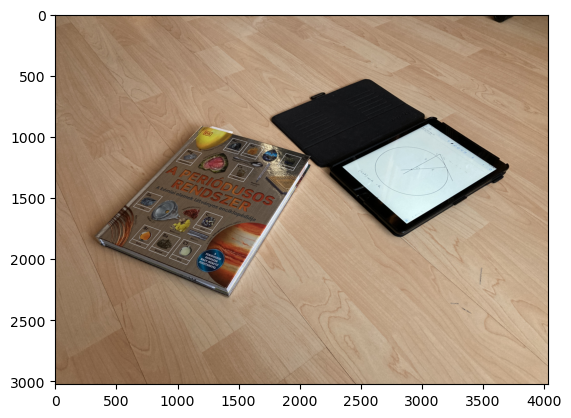

In [4]:
plt.imshow(img)

### Rectify method 1

In [5]:
x1 = np.array([360, 1816.0])
x2 = np.array([1400,2232.])
x3 = np.array([2088,1156.])
x4 = np.array([1232,923.])

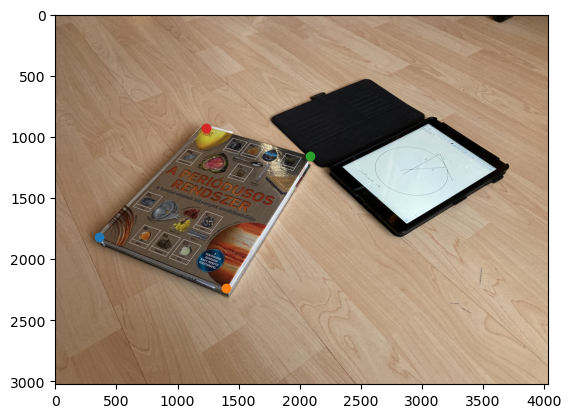

In [6]:
plt.scatter(x1[0], x1[1])
plt.scatter(x2[0], x2[1])
plt.scatter(x3[0], x3[1])
plt.scatter(x4[0], x4[1])
plt.imshow(img)

In [7]:
book_width = 22.0
book_height = 28.0

In [8]:
book_factor = 50.0
book_bottom_left_new = np.array([500., 2000.])
book_bottom_right_new = book_bottom_left_new + np.array([book_width, 0.0]) * book_factor
book_top_left_new = book_bottom_left_new + np.array([0.0, -book_height]) * book_factor
book_top_right_new = book_bottom_left_new + np.array([book_width, -book_height]) * book_factor

In [9]:
src = np.array([x1, x2, x3, x4]).astype(np.float32)
dst = np.array(
    [
        book_bottom_left_new,
        book_bottom_right_new,
        book_top_right_new,
        book_top_left_new,
    ]
).astype(np.float32)

In [10]:
src

array([[ 360., 1816.],
       [1400., 2232.],
       [2088., 1156.],
       [1232.,  923.]], dtype=float32)

In [11]:
dst

array([[ 500., 2000.],
       [1600., 2000.],
       [1600.,  600.],
       [ 500.,  600.]], dtype=float32)

In [12]:
H = cv2.getPerspectiveTransform(src, dst)

In [13]:
H

array([[    1.65352,     1.86463, -3012.85379],
       [   -0.64486,     2.70729,  -809.94917],
       [    0.00001,     0.00051,     1.     ]])

In [14]:
img.shape

(3024, 4032, 3)

In [15]:
img_warped = cv2.warpPerspective(img, H, (4032, 3024))

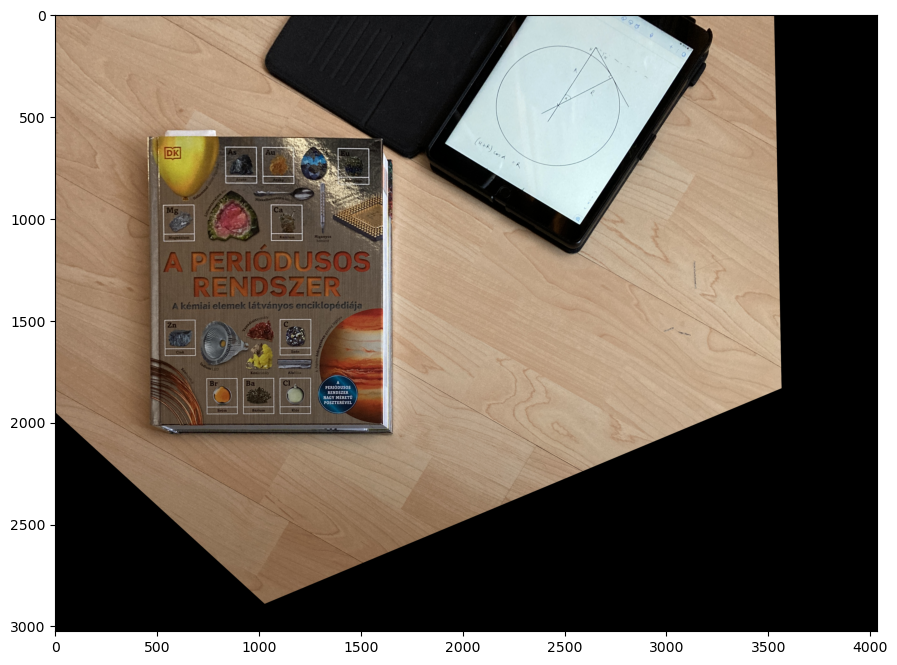

In [16]:
plt.figure(figsize=(15,8))
plt.imshow(img_warped)

In [17]:
Image.fromarray(img_warped).save("warped.png")

### Rectify method 2

In [5]:
p1 = np.array([2351,1248])
p2 = np.array([3054,896])
p3 = np.array([3613,1265])
p4 = np.array([2877,1714])

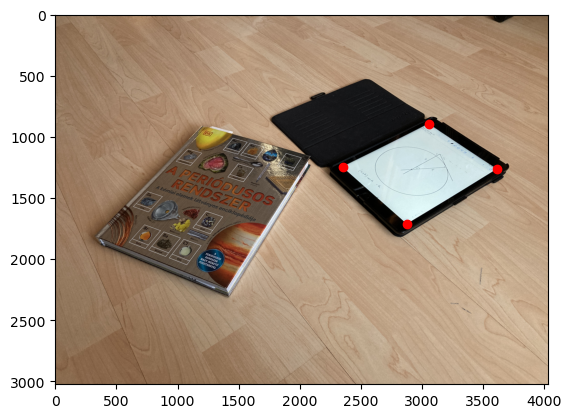

In [6]:
for p in [p1, p2, p3, p4]:
    plt.scatter(p[0], p[1], c="r")

plt.imshow(img)

In [7]:
def to_hom(x):
    return np.concatenate([x, [1.0]])

In [8]:
p1h = to_hom(p1)
p2h = to_hom(p2)
p3h = to_hom(p3)
p4h = to_hom(p4)

In [9]:
l_inf = np.cross(np.cross(np.cross(p1h, p2h), np.cross(p3h, p4h)), np.cross(np.cross(p1h, p4h), np.cross(p2h, p3h)))
print(l_inf)

[1.50978e+12 4.06093e+13 8.12354e+16]


In [10]:
l_inf / l_inf[-1]

array([0.00002, 0.0005 , 1.     ])

In [11]:
c1 = np.array([2885, 1476.])
c2 = np.array([3192,1387.])
c3 = np.array([3067,1131.])
c4 = np.array([2809,1091.])
c5 = np.array([2637,1189.])

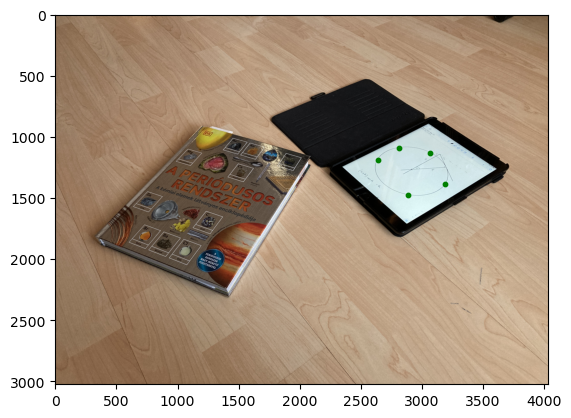

In [12]:
for p in [c1, c2, c3, c4, c5]:
    plt.scatter(p[0], p[1], c="g", s=10)

plt.imshow(img)

In [13]:
def conic_fit_A(points):
    points = np.asarray(points)
    N = points.shape[0]
    assert points.shape == (N, 2)
    a1 = points[:,0] ** 2
    a2 = points[:,0] * points[:,1]
    a3 = points[:,1]**2
    a4 = points[:,0]
    a5 = points[:,1]
    a6 = np.ones(N)
    A = np.column_stack([a1, a2, a3, a4, a5, a6])
    return A

In [14]:
A = conic_fit_A([c1, c2, c3, c4, c5])

In [15]:
A

array([[ 8323225.,  4258260.,  2178576.,     2885.,     1476.,        1.],
       [10188864.,  4427304.,  1923769.,     3192.,     1387.,        1.],
       [ 9406489.,  3468777.,  1279161.,     3067.,     1131.,        1.],
       [ 7890481.,  3064619.,  1190281.,     2809.,     1091.,        1.],
       [ 6953769.,  3135393.,  1413721.,     2637.,     1189.,        1.]])

In [16]:
cvec = np.linalg.svd(A)[2][-1]

In [17]:
cvec

array([ 0.     , -0.     ,  0.     , -0.0005 , -0.00043,  1.     ])

In [18]:
from multiview_geometry import proj2D

In [19]:
C = proj2D.cvec2C(cvec)

In [20]:
C

array([[ 0.     , -0.     , -0.00025],
       [-0.     ,  0.     , -0.00021],
       [-0.00025, -0.00021,  1.     ]])

In [24]:
pts = proj2D.get_conic_points(C, 0, 4000, 0, 4000, logmin=-7, logmax=7)

In [25]:
pts

[array([[2758.34089, 1434.12692],
        [2758.3538 , 1434.13358],
        [2758.36713, 1434.14045],
        ...,
        [2757.52839, 1433.70658],
        [2757.54169, 1433.71348],
        [2757.55457, 1433.72016]])]

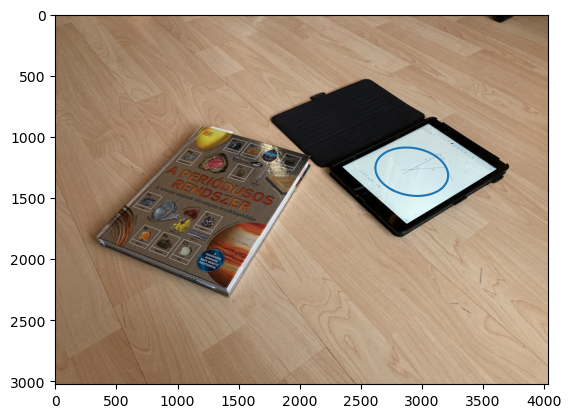

In [26]:
plt.plot(pts[0][:,0], pts[0][:,1])
plt.imshow(img)

In [31]:
C*1e6

array([[     0.09606,     -0.02219,   -251.65965],
       [    -0.02219,      0.21662,   -213.53678],
       [  -251.65965,   -213.53678, 999999.78214]])

In [33]:
l_inf * 1e-12

array([    1.50978,    40.60932, 81235.41706])